# 🧠 Medical Imaging Final Project:
# Brain Tumor Classification: VGG16, EfficientNet, Resnet101, XCeption
### MIC — Spring 2025  
### **Team 1**

**Team Members:**  
- Lam Nguyen  
- Faramarz Aboutalebi  

---

This project focuses on applying deep learning techniques for tumor classification in MRI brain scans using convolutional neural networks and interpretability tools. The notebook includes data preprocessing, model training with transfer learning, performance evaluation, visualization techniques (Grad-CAM, ROC, PR curves), and several diagnostic tools.


# Step 1: Environment Setup and Library Imports

In [ ]:
%pip install -r requirements.txt

In [1]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageEnhance
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization,Input,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Check if GPU is available and show basic info
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("🔋 GPU detected — accelerated training enabled.")
    for device in gpu_devices:
        print("Device in use:", device)
else:
    print("⚙️ Training will proceed on CPU — no GPU found.")

# Print Dataset
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-04-21 16:05:15.137579: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 16:05:15.144843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745265915.153965   67814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745265915.156930   67814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 16:05:15.166459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

🔋 GPU detected — accelerated training enabled.
Device in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
dataset/brain.tar.gz
dataset/Testing/glioma/Te-glTr_0000.jpg
dataset/Testing/glioma/Te-glTr_0001.jpg
dataset/Testing/glioma/Te-glTr_0002.jpg
dataset/Testing/glioma/Te-glTr_0003.jpg
dataset/Testing/glioma/Te-glTr_0004.jpg
dataset/Testing/glioma/Te-glTr_0005.jpg
dataset/Testing/glioma/Te-glTr_0006.jpg
dataset/Testing/glioma/Te-glTr_0007.jpg
dataset/Testing/glioma/Te-glTr_0008.jpg
dataset/Testing/glioma/Te-glTr_0009.jpg
dataset/Testing/glioma/Te-gl_0010.jpg
dataset/Testing/glioma/Te-gl_0011.jpg
dataset/Testing/glioma/Te-gl_0012.jpg
dataset/Testing/glioma/Te-gl_0013.jpg
dataset/Testing/glioma/Te-gl_0014.jpg
dataset/Testing/glioma/Te-gl_0015.jpg
dataset/Testing/glioma/Te-gl_0017.jpg
dataset/Testing/glioma/Te-gl_0018.jpg
dataset/Testing/glioma/Te-gl_0019.jpg
dataset/Testing/glioma/Te-gl_0020.jpg
dataset/Testing/glioma/Te-gl_0021.jpg
dataset/Testing/glioma/Te-gl_0022.

# Step 2: Dataset Path Setup and Class Mapping

In [2]:
# Configure dataset paths relative to project location
project_root = os.getcwd()
train_path = os.path.join(project_root, "dataset", "Training")
test_path = os.path.join(project_root, "dataset", "Testing")


X_train = []
y_train = []
labels = ['glioma','notumor','meningioma','pituitary']


image_size = 150
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)



100%|██████████| 300/300 [00:00<00:00, 1823.34it/s]


# Step 3: Data Visualization

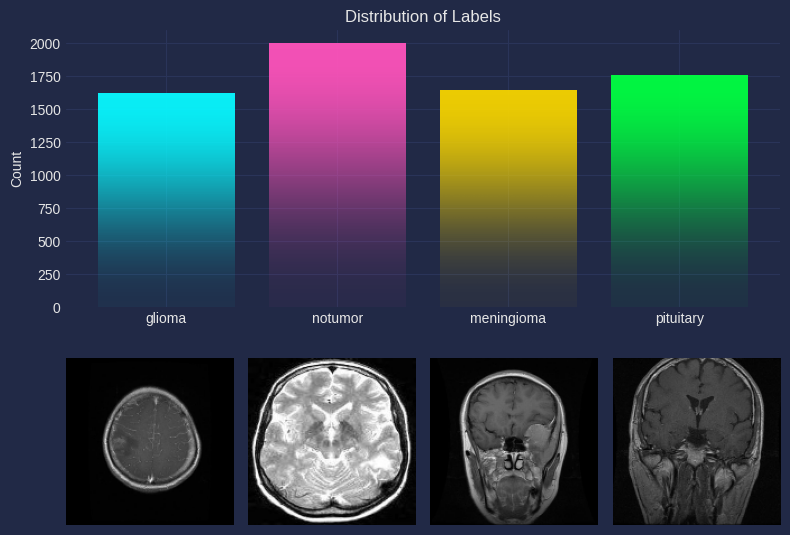

In [3]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

### Random Sample Image and Preview

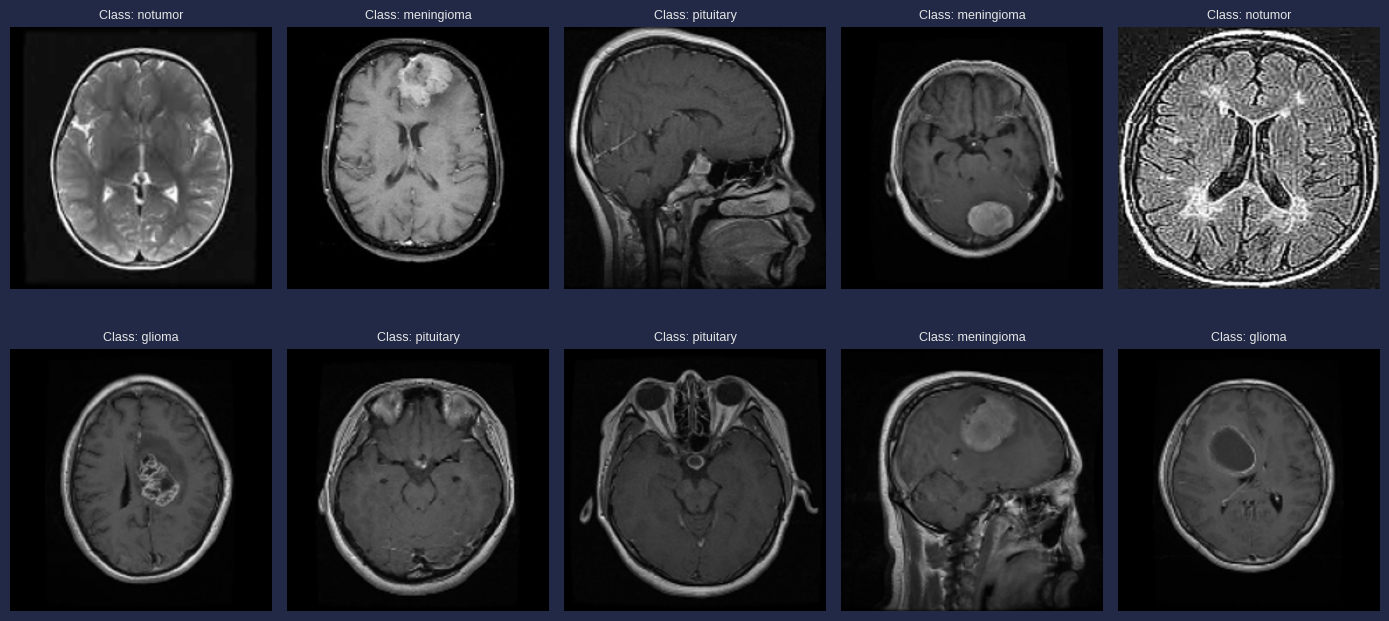

In [4]:
# Preview a few training images with labels
def preview_samples(images, labels, count=10):
    selected = random.sample(range(len(images)), count)
    fig, axarr = plt.subplots(2, 5, figsize=(14, 7))
    axarr = axarr.flatten()

    for i, idx in enumerate(selected):
        # Convert NumPy array to PIL Image (no .open() needed)
        img = Image.fromarray(images[idx]).resize((224, 224)) # Use fromarray() instead of open
        #img = Image.open(images[idx]).resize((224, 224))
        axarr[i].imshow(img)
        axarr[i].axis('off')
        axarr[i].set_title(f"Class: {labels[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()

# Display random examples from training set
preview_samples(X_train, y_train)

# Step 4: Preprocessing Functions (Augmentation, Normalization)

### Dataset Split and Train

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

### One Hot Encoding Labels

In [6]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Step 05: Compile and Train VGG16

In [7]:
# Load VGG16 pretrained on ImageNet (without top layers)
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)  # Ensure `image_size` is defined (e.g., 224)
)

vgg16.trainable = False


# Build custom model on top of VGG16

model = vgg16.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=vgg16.input, outputs=model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1745265940.759241   67814 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1050 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("vgg16_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=8,
    callbacks=[tensorboard, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/15


I0000 00:00:1745265963.251619   68141 service.cc:148] XLA service 0x792c0c00d100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745265963.251638   68141 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2025-04-21 16:06:03.269393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745265963.386295   68141 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1745265963.833123   68141 buffer_comparator.cc:157] Difference at 16: 0.0755644, expected 8.13329
E0000 00:00:1745265963.833151   68141 buffer_comparator.cc:157] Difference at 17: 0.805029, expected 7.89303
E0000 00:00:1745265963.833153   68141 buffer_comparator.cc:157] Difference at 18: 0.658462, expected 8.12246
E0000 00:00:1745265963.833154   68141 buffer_comparator.cc:157] Difference at 19: 0.771946, ex

 22/711 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3635 - loss: 8.3760

I0000 00:00:1745265964.751779   68141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6394 - loss: 2.4615
Epoch 1: val_accuracy improved from -inf to 0.86551, saving model to vgg16_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6399 - loss: 2.4545 - val_accuracy: 0.8655 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 2/15
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8183 - loss: 0.4787
Epoch 2: val_accuracy improved from 0.86551 to 0.87342, saving model to vgg16_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8184 - loss: 0.4786 - val_accuracy: 0.8734 - val_loss: 0.3053 - learning_rate: 0.0010
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8643 - loss: 0.3653
Epoch 3: val_accuracy improved from 0.87342 to 0.89715, saving model to vgg16_checkpoint.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8643 - loss: 0.3654 - val_accuracy: 0.8972 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 4/15
708/711 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [11]:
model.save('checkpoints/vgg16_checkpoint.keras')

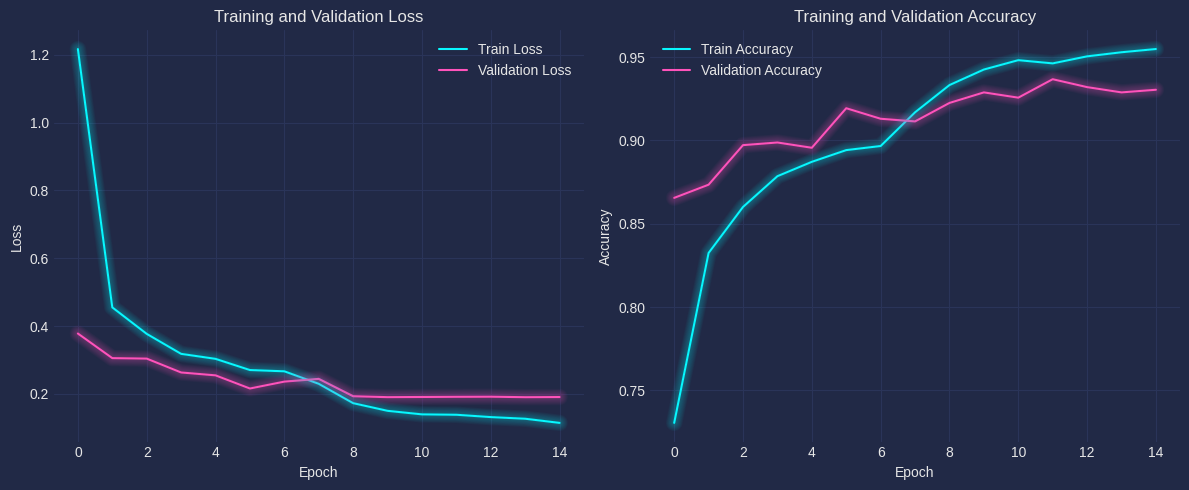

In [12]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

In [13]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

E0000 00:00:1745266088.541581   68141 buffer_comparator.cc:157] Difference at 64: 0, expected 65.5665
E0000 00:00:1745266088.541607   68141 buffer_comparator.cc:157] Difference at 65: 0, expected 66.58
E0000 00:00:1745266088.541609   68141 buffer_comparator.cc:157] Difference at 66: 1, expected 66.6736
E0000 00:00:1745266088.541611   68141 buffer_comparator.cc:157] Difference at 67: 0, expected 70.0884
E0000 00:00:1745266088.541612   68141 buffer_comparator.cc:157] Difference at 68: 1, expected 67.9127
E0000 00:00:1745266088.541613   68141 buffer_comparator.cc:157] Difference at 69: 0, expected 69.0353
E0000 00:00:1745266088.541614   68141 buffer_comparator.cc:157] Difference at 70: 0, expected 70.3397
E0000 00:00:1745266088.541615   68141 buffer_comparator.cc:157] Difference at 71: 0, expected 75.2098
E0000 00:00:1745266088.541616   68141 buffer_comparator.cc:157] Difference at 72: 0, expected 64.8238
E0000 00:00:1745266088.541617   68141 buffer_comparator.cc:157] Difference at 73: 1,

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_67814/1941499279.py", line 2, in <module>

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 560, in predict

  File "/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.40 = (f32[32,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,150,150]{3,2,1,0} %get-tuple-element.26, f32[64,64,3,3]{3,2,1,0} %bitcast.448, f32[64]{0} %arg4.5), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv2_1/convolution" source_file="/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 201097216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_137978]

In [ ]:
print(classification_report(y_true_test,y_pred_test))

In [ ]:
# ROC Curve

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Prediction

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/vgg16_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=128):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)

### Precision-Recall Curves

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()


### Upload and Detect Images

In [ ]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()


### Export to CSV (Predictions + Ground Truth)

In [ ]:
import pandas as pd

# Export test results to CSV
pred_labels = [tumor_types[i] for i in y_pred]
true_labels = [tumor_types[i] for i in y_test]

df_results = pd.DataFrame({
    "Image": test_images,
    "True Label": true_labels,
    "Predicted Label": pred_labels
})
df_results.to_csv("prediction_results.csv", index=False)
print("✅ Results saved to prediction_results.csv")

### Top-K Accuracy Visualization

In [ ]:
# Calculate top-k accuracy for top-1, top-2, top-3
def compute_top_k_accuracies(probs, true_labels, k_list=[1, 2, 3]):
    results = {}
    for k in k_list:
        top_k_preds = np.argsort(probs, axis=1)[:, -k:]
        correct = sum([true_labels[i] in top_k_preds[i] for i in range(len(true_labels))])
        results[k] = correct / len(true_labels)
    return results

topk_scores = compute_top_k_accuracies(y_prob, y_test)

colors = ["C0", "C1", "C2", "C3"]

# Plot top-k results
plt.figure(figsize=(6, 4))
bars=plt.bar([f"Top-{k}" for k in topk_scores], topk_scores.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.ylim(0, 1)
plt.title("Top-k Prediction Accuracy")
plt.ylabel("Accuracy")
plt.grid(True, axis='y')
plt.show()


### Confidence Plot Cell

In [ ]:
# Confidence for each test prediction
confidences = np.max(y_prob, axis=1)

plt.figure(figsize=(10, 4))
plt.bar(range(len(confidences)), confidences, color='pink')
plt.title("Prediction Confidence per Sample")
plt.xlabel("Test Sample Index")
plt.ylabel("Confidence Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
mplcyberpunk.make_lines_glow()
plt.show()

### Misclassified Images Viewer

In [ ]:
# Show incorrect predictions with actual and predicted labels
wrong_idxs = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
print(f"❌ Misclassified Samples: {len(wrong_idxs)}")

for idx in wrong_idxs[:5]:  # show first 5 mistakes
    img = Image.open(test_images[idx])
    plt.imshow(img)
    plt.title(f"True: {tumor_types[y_test[idx]]}, Pred: {tumor_types[y_pred[idx]]}")
    plt.axis('off')
    plt.show()

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

# Step 06: Compile and Train EfficientNet

In [ ]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 15, verbose = 1,
                    batch_size = 32, callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
model.save('checkpoints/efficientnet_checkpoint.keras')

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()


### Evaluation

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

### ROC Curve

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("EfficientNet ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

### Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

In [ ]:
!nvidia-smi

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()


# Step 07: Compile and Train ResNet101

In [ ]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/resnet101_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
model.save('checkpoints/resnet101_checkpoint.keras')

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 
conf_matrix = confusion_matrix(y_true_test,y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)


heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC Curve

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

## Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

# Step 08: Compile and Train XCeption

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()

In [ ]:
# Load the Xception model pretrained on ImageNet without the top layers
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))

# Build the custom model on top of the Xception base
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1536,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("checkpoints/xception_checkpoint.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

### ROC Curve

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("Xception ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ResNet101 ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = X_test
y_test = y_test
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("XCeption ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))

### Prediction

In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class] 

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)
tf.compat.v1.reset_default_graph()